In [1]:
import numpy as np
import matplotlib.pyplot as plt


from optigrid import optigrid



# First, generate two separate normal distributions and noise
normal1_mean = [-5, -5, 1]
normal1_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 0.05]]
normal1_samples = 10000
normal1 = np.random.multivariate_normal(mean=normal1_mean, cov=normal1_cov, size=normal1_samples)

normal2_mean = [5, 0, -1]
normal2_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 0.05]]
normal2_samples = 20000
normal2 = np.random.multivariate_normal(mean=normal2_mean, cov=normal2_cov, size=normal2_samples)

noise_low = [-10, -10, -10]
noise_high = [10, 10, 10]
noise_samples = 10000
noise = np.random.uniform(low=noise_low, high=noise_high, size=(noise_samples, 3))

data = np.concatenate((normal1, normal2))#, noise))

# Weight the samples from the first population twice as high
weights = np.array([2] * normal1_samples + [1] * normal2_samples)

# Now we want to standard scale our data. Although it is not necessary, it is recommended for better selection of the parameters and uniform importance of the dimensions.
data_scaled = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Next, chose the parameters
d = 3 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = 0.1
max_cut_score = 0.3
bandwidth = 0.1

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=True)
optigrid_test.fit(data_scaled, weights=weights)
### Output: 
###     In current cluster: 47.08% of datapoints
###     In current cluster: 52.92% of datapoints
###     Optigrid found 2 clusters.

for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))
### Output: 
###     Cluster 0: Mean=[-5.03474967 -3.3355985   0.6569438 ], Std=[1.79700025 4.11403245 3.33377444]
###     Cluster 1: Mean=[ 4.92505754  0.05634452 -0.62898176], Std=[1.92237979 3.49116619 3.46671477]

# Draw a 10 values from both normals and score it with optigrid after normalization
sample_size = 10
sample1 = np.random.multivariate_normal(normal1_mean, normal1_cov, sample_size)
sample2 = np.random.multivariate_normal(normal2_mean, normal2_cov, sample_size)
sample = np.concatenate((sample1, sample2))
sample = (sample - np.mean(data)) / np.std(data)

result = optigrid_test.score_samples(sample)
print(result)
### Output: 
###     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
### The first ten values belong to the zeroth cluster and the latter ten to the second cluster as expected

Found following cuts: [(-0.34940034966674793, 0, 0.00011534487534518079)]
Evaluating subgrid: 50.00% of datapoints
Found cluster 0: 50.00% of datapoints
Evaluating subgrid: 50.00% of datapoints
Found cluster 1: 50.00% of datapoints
Optigrid found 2 clusters.
Cluster 0: Mean=[-5.00397755 -5.00675476  1.00157498], Std=[1.00853009 1.00505119 0.22184639]
Cluster 1: Mean=[ 4.99179309e+00 -1.96834400e-03 -1.00231064e+00], Std=[1.0059022  0.99565247 0.22703863]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Cluster 0: Mean=[-5.00397755 -5.00675476  1.00157498], Std=[1.00853009 1.00505119 0.22184639]
Cluster 1: Mean=[ 4.99179309e+00 -1.96834400e-03 -1.00231064e+00], Std=[1.0059022  0.99565247 0.22703863]


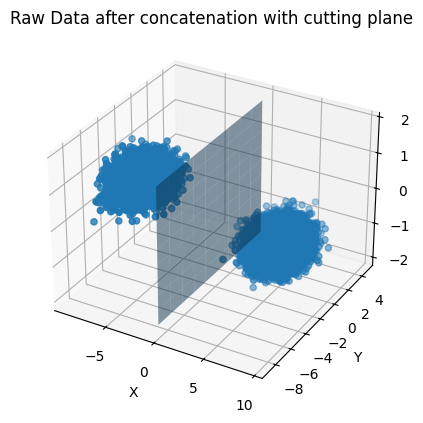

In [2]:
#create 3d plot of the data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Raw Data after concatenation')


mean_points = np.array([])
for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    if mean_points.size == 0:
        mean_points = np.mean(cluster_data, axis=0)
    else:        
        mean_points= np.vstack((mean_points, np.mean(cluster_data, axis=0)))
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))


#for i, mean_point in enumerate(mean_points):
#    ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='r', marker='o')
#    ax.text(mean_point[0], mean_point[1], mean_point[2], 'Cluster {}'.format(i), color='black')

#ax.plot(mean_points[:,0], mean_points[:,1], mean_points[:,2], c='r')
#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#plot all cutting planes
n_points = 10
cutting_planes = optigrid_test.root.cutting_planes
for cutting_plane in cutting_planes:
    if cutting_plane[1] == 0:
        x = cutting_plane[0] * np.ones(n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        y, z = np.meshgrid(y, z)
    elif cutting_plane[1] == 1:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = cutting_plane[0] * np.ones(n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        x, z = np.meshgrid(x, z)
    else:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = cutting_plane[0] * np.ones(n_points)
        x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, z, alpha=0.5)
    ax.title.set_text('Raw Data after concatenation with cutting plane')


plt.show()

Cluster 0: Mean=[-5.00397755 -5.00675476  1.00157498], Std=[1.00853009 1.00505119 0.22184639]
Cluster 1: Mean=[ 4.99179309e+00 -1.96834400e-03 -1.00231064e+00], Std=[1.0059022  0.99565247 0.22703863]


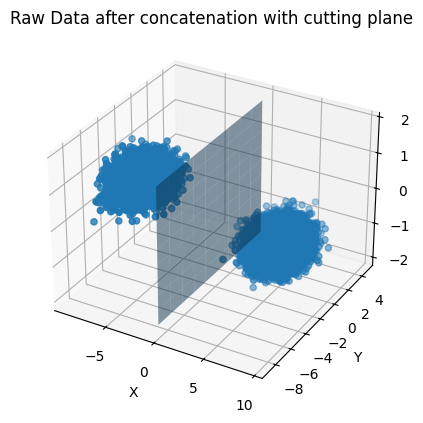

In [3]:
#create 3d plot of the data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Raw Data after concatenation')


mean_points = np.array([])
for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    if mean_points.size == 0:
        mean_points = np.mean(cluster_data, axis=0)
    else:        
        mean_points= np.vstack((mean_points, np.mean(cluster_data, axis=0)))
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))


#for i, mean_point in enumerate(mean_points):
#    ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='r', marker='o')
#    ax.text(mean_point[0], mean_point[1], mean_point[2], 'Cluster {}'.format(i), color='black')

#ax.plot(mean_points[:,0], mean_points[:,1], mean_points[:,2], c='r')
#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#plot all cutting planes
n_points = 10
cutting_planes = optigrid_test.root.cutting_planes
for cutting_plane in cutting_planes:
    if cutting_plane[1] == 0:
        x = cutting_plane[0] * np.ones(n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        y, z = np.meshgrid(y, z)
    elif cutting_plane[1] == 1:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = cutting_plane[0] * np.ones(n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        x, z = np.meshgrid(x, z)
    else:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = cutting_plane[0] * np.ones(n_points)
        x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, z, alpha=0.5)
    ax.title.set_text('Raw Data after concatenation with cutting plane')


plt.show()

Cluster 0: Mean=[-5.00397755 -5.00675476  1.00157498], Std=[1.00853009 1.00505119 0.22184639]
Cluster 1: Mean=[ 4.99179309e+00 -1.96834400e-03 -1.00231064e+00], Std=[1.0059022  0.99565247 0.22703863]


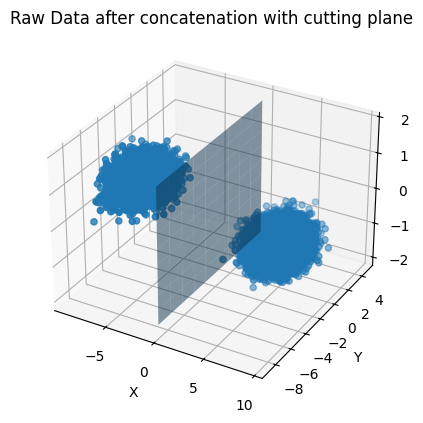

In [4]:
#create 3d plot of the data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Raw Data after concatenation')


mean_points = np.array([])
for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    if mean_points.size == 0:
        mean_points = np.mean(cluster_data, axis=0)
    else:        
        mean_points= np.vstack((mean_points, np.mean(cluster_data, axis=0)))
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))


#for i, mean_point in enumerate(mean_points):
#    ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='r', marker='o')
#    ax.text(mean_point[0], mean_point[1], mean_point[2], 'Cluster {}'.format(i), color='black')

#ax.plot(mean_points[:,0], mean_points[:,1], mean_points[:,2], c='r')
#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#plot all cutting planes
n_points = 10
cutting_planes = optigrid_test.root.cutting_planes
for cutting_plane in cutting_planes:
    if cutting_plane[1] == 0:
        x = cutting_plane[0] * np.ones(n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        y, z = np.meshgrid(y, z)
    elif cutting_plane[1] == 1:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = cutting_plane[0] * np.ones(n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        x, z = np.meshgrid(x, z)
    else:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = cutting_plane[0] * np.ones(n_points)
        x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, z, alpha=0.5)
    ax.title.set_text('Raw Data after concatenation with cutting plane')


plt.show()

Cluster 0: Mean=[-5.00397755 -5.00675476  1.00157498], Std=[1.00853009 1.00505119 0.22184639]
Cluster 1: Mean=[ 4.99179309e+00 -1.96834400e-03 -1.00231064e+00], Std=[1.0059022  0.99565247 0.22703863]


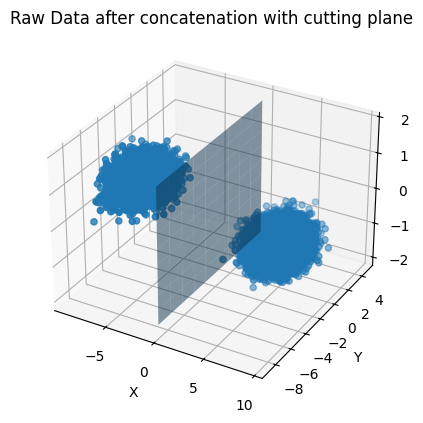

In [5]:
#create 3d plot of the data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Raw Data after concatenation')


mean_points = np.array([])
for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    if mean_points.size == 0:
        mean_points = np.mean(cluster_data, axis=0)
    else:        
        mean_points= np.vstack((mean_points, np.mean(cluster_data, axis=0)))
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))


#for i, mean_point in enumerate(mean_points):
#    ax.scatter(mean_point[0], mean_point[1], mean_point[2], c='r', marker='o')
#    ax.text(mean_point[0], mean_point[1], mean_point[2], 'Cluster {}'.format(i), color='black')

#ax.plot(mean_points[:,0], mean_points[:,1], mean_points[:,2], c='r')
#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#plot all cutting planes
n_points = 10
cutting_planes = optigrid_test.root.cutting_planes
for cutting_plane in cutting_planes:
    if cutting_plane[1] == 0:
        x = cutting_plane[0] * np.ones(n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        y, z = np.meshgrid(y, z)
    elif cutting_plane[1] == 1:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = cutting_plane[0] * np.ones(n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        x, z = np.meshgrid(x, z)
    else:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = cutting_plane[0] * np.ones(n_points)
        x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, z, alpha=0.5)
    ax.title.set_text('Raw Data after concatenation with cutting plane')


plt.show()

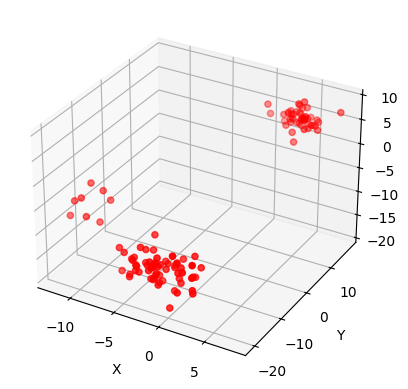

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.decomposition import PCA


def generate_cluster_centers(num_clusters, min_val, max_val):
    cluster_centers = np.random.uniform(min_val, max_val, size=(num_clusters, 3))
    return cluster_centers

def generate_cluster_data(cluster_centers, num_points, mean_distance, std_dev, cluster_label_set=None, random_std= False, random_total_points=False):
    cluster_data = []
    labels = []


    for ix, center in enumerate(cluster_centers):
        
        if random_std == True:
            std_dev_distance = np.random.uniform(0, std_dev)
        else:
            std_dev_distance = std_dev
        
        if random_total_points==True:            
            total_points = np.random.randint(0, num_points)
        else:
            total_points = num_points

        points = np.random.normal(loc=center, scale=std_dev_distance, size=(total_points, 3))
        labels.extend([cluster_label_set[ix]] * total_points)
        cluster_data.append(points)
    return np.concatenate(cluster_data), labels

def generate_cluster_labels(num_clusters):
    alphabet = string.ascii_uppercase
    labels = []
    for i in range(num_clusters):
        if i < 26:
            label = alphabet[i]
        else:
            label = f"{alphabet[i % 26]}{i // 26}"
        labels.extend([label] )
    return labels



num_clusters = 3
min_val = -20   # min and max values for the cluster centers
max_val = 20
total_points = 100
mean_distance = 9.0
std_dev_distance = 2

# Generate cluster labels
cluster_label_set = generate_cluster_labels(num_clusters)
cluster_centers = generate_cluster_centers(num_clusters, min_val, max_val)
cluster_data, cluster_labels = generate_cluster_data(cluster_centers, total_points, mean_distance, std_dev_distance, cluster_label_set,True, True)

# Plotting the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], c='r', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


# Attach cluster labels to each datapoint
labeled_cluster_data = np.column_stack((cluster_data, cluster_labels))
raw_data = np.copy(cluster_data)


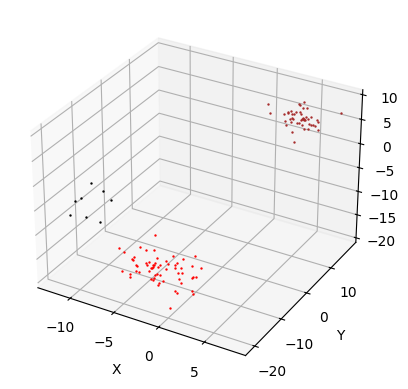

In [7]:
import matplotlib.pyplot as plt

# Define the resistor color code colors
colors = ['black', 'brown', 'red', 'orange', 'yellow', 'green', 'blue', 'violet', 'gray', 'white']

# Plotting the clusters in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Assign a unique color to each cluster
unique_labels = set(cluster_labels)
num_clusters = len(unique_labels)
#map colors to cluster labels by creating a dictionary
#loop through number of clusters and assign a color to each cluster using the colors list and cluster index mod 10
color_map = dict(zip(unique_labels, [colors[i % 10] for i in range(num_clusters)]))


# Plot each data point with its corresponding cluster color
for i, label in enumerate(cluster_labels):
    ax.scatter(cluster_data[i, 0], cluster_data[i, 1], cluster_data[i, 2], c=color_map[label], marker='o', s=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [8]:
print(cluster_data.shape)
print(data.shape)

(117, 3)
(30000, 3)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from optigrid import optigrid


# Next, chose the parameters
d = 3 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = .1
max_cut_score = .1
bandwidth = 0.005

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=True)
optigrid_test.fit(cluster_data)


for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data_x = np.take(cluster_data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data_x, axis=0), np.std(cluster_data_x, axis=0)))
### Output: 
###     Cluster 0: Mean=[-5.03474967 -3.3355985   0.6569438 ], Std=[1.79700025 4.11403245 3.33377444]
###     Cluster 1: Mean=[ 4.92505754  0.05634452 -0.62898176], Std=[1.92237979 3.49116619 3.46671477]

# Draw a 10 values from both normals and score it with optigrid after normalization
sample_size = 10
sample1 = np.random.multivariate_normal(normal1_mean, normal1_cov, sample_size)
sample2 = np.random.multivariate_normal(normal2_mean, normal2_cov, sample_size)
sample = np.concatenate((sample1, sample2))
sample = (sample - np.mean(cluster_data)) / np.std(cluster_data)

result = optigrid_test.score_samples(sample)
print(result)
### Output: 
###     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
### The first ten values belong to the zeroth cluster and the latter ten to the second cluster as expected

Found following cuts: [(-11.92236371358563, 0, 0.0)]


TypeError: 'NoneType' object is not subscriptable

IndexError: index 2 is out of bounds for axis 1 with size 2

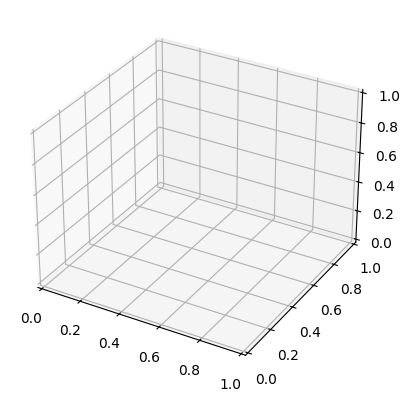

In [ ]:
#create 3d plot of the data

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.title.set_text('Raw Data after concatenation')


#we will plot ax.plot_surface to show the cutting plane
#the dimension of the cutting plane is either the x plane, y plane or z plane which is determined by optigrid_test.root.cutting_plane[1]
#the fixed value in the dimension is determined by optigrid_test.root.cutting_plane[0]
#the range of the cutting plane is determined by optigrid_test.root.cutting_plane[2]

#plot all cutting planes
n_points = 10
cutting_planes = optigrid_test.root.cutting_planes
for cutting_plane in cutting_planes:
    if cutting_plane[1] == 0:
        x = cutting_plane[0] * np.ones(n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        y, z = np.meshgrid(y, z)
    elif cutting_plane[1] == 1:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = cutting_plane[0] * np.ones(n_points)        
        z = np.linspace(np.min(data[:,2]), np.max(data[:,2]), n_points)
        x, z = np.meshgrid(x, z)
    else:
        x =  np.linspace(np.min(data[:,0]), np.max(data[:,0]), n_points)
        y = np.linspace(np.min(data[:,1]), np.max(data[:,1]), n_points)        
        z = cutting_plane[0] * np.ones(n_points)
        x, y = np.meshgrid(x, y)
    ax.plot_surface(x, y, z, alpha=0.5)
    ax.title.set_text('Raw Data after concatenation with cutting plane')


plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt


from optigrid import optigrid


#random seed 42
np.random.seed(42)


# First, generate two separate normal distributions and noise
normal1_mean = [-5, -5]
normal1_cov = [[1, 0], [0, 1]]
normal1_samples = 10000
normal1 = np.random.multivariate_normal(mean=normal1_mean, cov=normal1_cov, size=normal1_samples)

normal2_mean = [5, 0]
normal2_cov = [[1, 0.2], [0.2, 1]]
normal2_samples = 20000
normal2 = np.random.multivariate_normal(mean=normal2_mean, cov=normal2_cov, size=normal2_samples)

normal3_mean = [0, 5]
normal3_cov = [[1, 0.2], [0.2, 1]]
normal3_samples = 20000
normal3 = np.random.multivariate_normal(mean=normal3_mean, cov=normal3_cov, size=normal3_samples)

normal4_mean = [-7, 20]
normal4_cov = [[1, 0.1], [.1, 1]]
normal4_samples = 20000
normal4 = np.random.multivariate_normal(mean=normal4_mean, cov=normal4_cov, size=normal4_samples)


noise_low = [-20, -20]
noise_high = [20, 20]
noise_samples = 1000
noise = np.random.uniform(low=noise_low, high=noise_high, size=(noise_samples, 2))

data = np.concatenate((normal1, normal2, normal3, normal4, noise))

# Weight the samples from the first population twice as high
weights = np.array([1] * normal1_samples + [1] * normal2_samples + [1] * normal3_samples + [1] * normal4_samples + [1] * noise_samples)

# Now we want to standard scale our data. Although it is not necessary, it is recommended for better selection of the parameters and uniform importance of the dimensions.
data_scaled = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

# Next, chose the parameters
d = 2 # Number of dimensions
q = 1 # Number of cutting planes per step
noise_level = 0.1
max_cut_score = 1
bandwidth = 0.08

# Fit Optigrid to the data
optigrid_test = optigrid.Optigrid(d=d, q=q, max_cut_score=max_cut_score, noise_level=noise_level, kde_bandwidth=bandwidth, verbose=True)
optigrid_test.fit(data_scaled, weights=weights)
### Output: 
###     In current cluster: 47.08% of datapoints
###     In current cluster: 52.92% of datapoints
###     Optigrid found 2 clusters.

for i, cluster in enumerate(optigrid_test.clusters):
    cluster_data = np.take(data, cluster, axis=0) # Clusters are stored as indices pointing to the original data
    print("Cluster {}: Mean={}, Std={}".format(i, np.mean(cluster_data, axis=0), np.std(cluster_data, axis=0)))
### Output: 
###     Cluster 0: Mean=[-5.03474967 -3.3355985   0.6569438 ], Std=[1.79700025 4.11403245 3.33377444]
###     Cluster 1: Mean=[ 4.92505754  0.05634452 -0.62898176], Std=[1.92237979 3.49116619 3.46671477]

# Draw a 10 values from both normals and score it with optigrid after normalization
sample_size = 10
sample1 = np.random.multivariate_normal(normal1_mean, normal1_cov, sample_size)
sample2 = np.random.multivariate_normal(normal2_mean, normal2_cov, sample_size)
sample = np.concatenate((sample1, sample2))
sample = (sample - np.mean(data)) / np.std(data)

result = optigrid_test.score_samples(sample)
print(result)
### Output: 
###     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
### The first ten values belong to the zeroth cluster and the latter ten to the second cluster as expected

Found following cuts: [(0.7467733836769326, 1, 2.363555854663022e-08)]
Evaluating subgrid: 71.83% of datapoints
Found following cuts: [(-0.2948727952073096, 0, 0.04742959515038131)]
Evaluating subgrid: 14.55% of datapoints
Found cluster 0: 14.55% of datapoints
Evaluating subgrid: 57.28% of datapoints
Found following cuts: [(0.7651735004761551, 0, 0.0703263179255136)]
Evaluating subgrid: 28.55% of datapoints
Found cluster 1: 28.55% of datapoints
Evaluating subgrid: 28.73% of datapoints
Found cluster 2: 28.73% of datapoints
Evaluating subgrid: 28.17% of datapoints
Found cluster 3: 28.17% of datapoints
Optigrid found 4 clusters.
Cluster 0: Mean=[-5.05218736 -4.74089425], Std=[1.07034057 1.87269851]
Cluster 1: Mean=[-0.01120433  4.84519786], Std=[0.9996224  1.56196972]
Cluster 2: Mean=[5.03322628 0.02828804], Std=[1.04183955 1.35133995]
Cluster 3: Mean=[-7.00619746 19.98920742], Std=[1.00486828 0.99583695]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


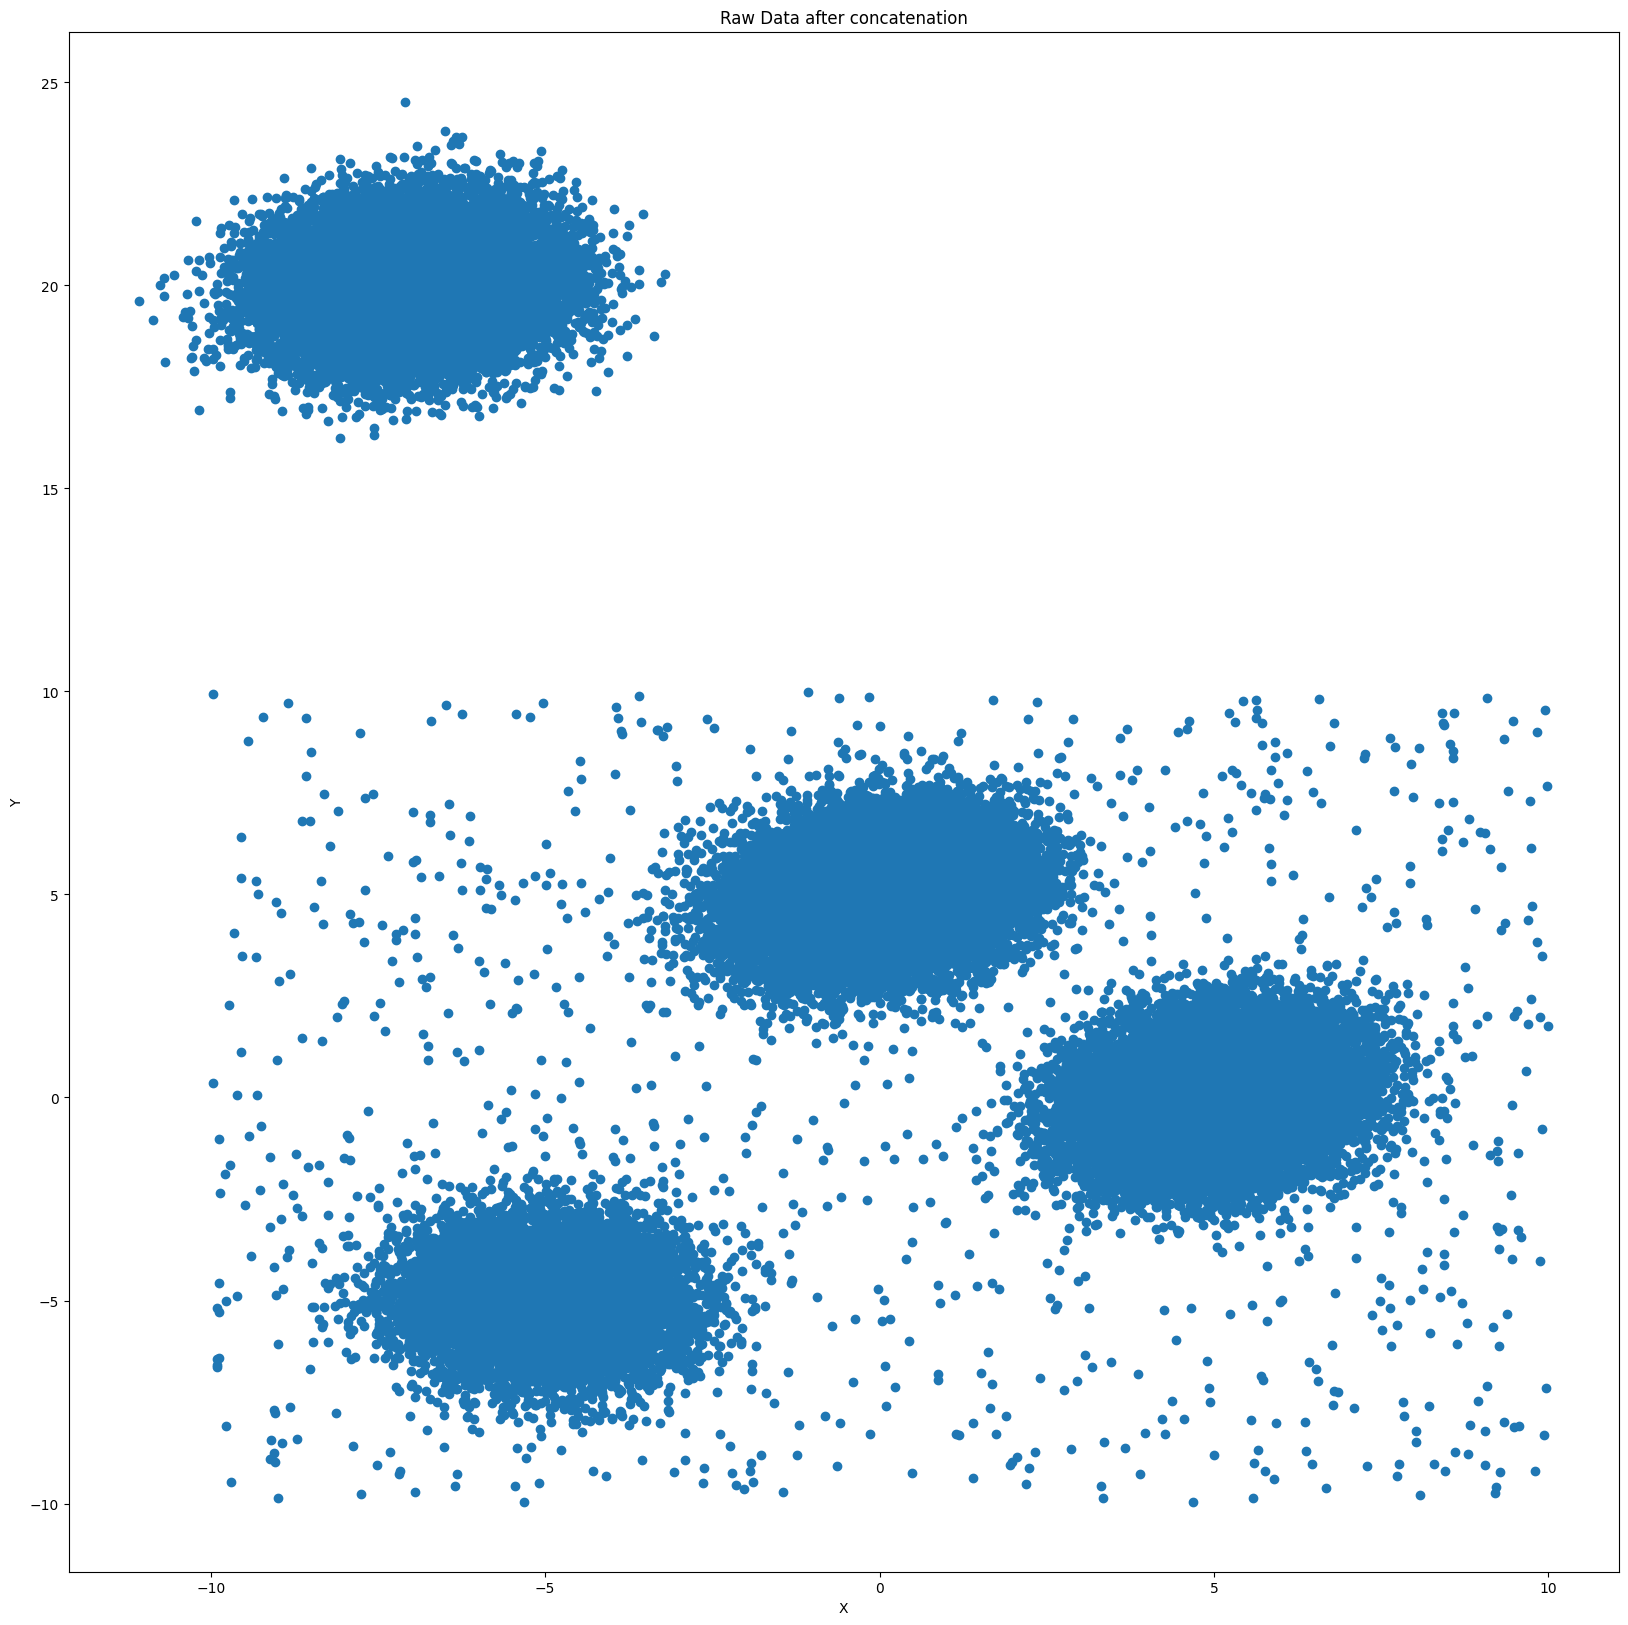

branch node - [(0.7467733836769326, 1, 2.363555854663022e-08)], side=-1, d_prev=-1, x0=-11.075, x1=9.998, y0=-9.956, y1=24.525
branch node - [(-0.2948727952073096, 0, 0.04742959515038131)], side=0, d_prev=1, x0=-11.075, x1=9.998, y0=-9.956, y1=0.747
leaf node - 0, side=0, d_prev=0, x0=-11.075, x1=-0.295, y0=-9.956, y1=0.747
branch node - [(0.7651735004761551, 0, 0.0703263179255136)], side=1, d_prev=0, x0=-0.295, x1=9.998, y0=-9.956, y1=0.747
leaf node - 1, side=0, d_prev=0, x0=-0.295, x1=0.765, y0=-9.956, y1=0.747
leaf node - 2, side=1, d_prev=0, x0=0.765, x1=9.998, y0=-9.956, y1=0.747
leaf node - 3, side=1, d_prev=1, x0=-11.075, x1=9.998, y0=0.747, y1=24.525


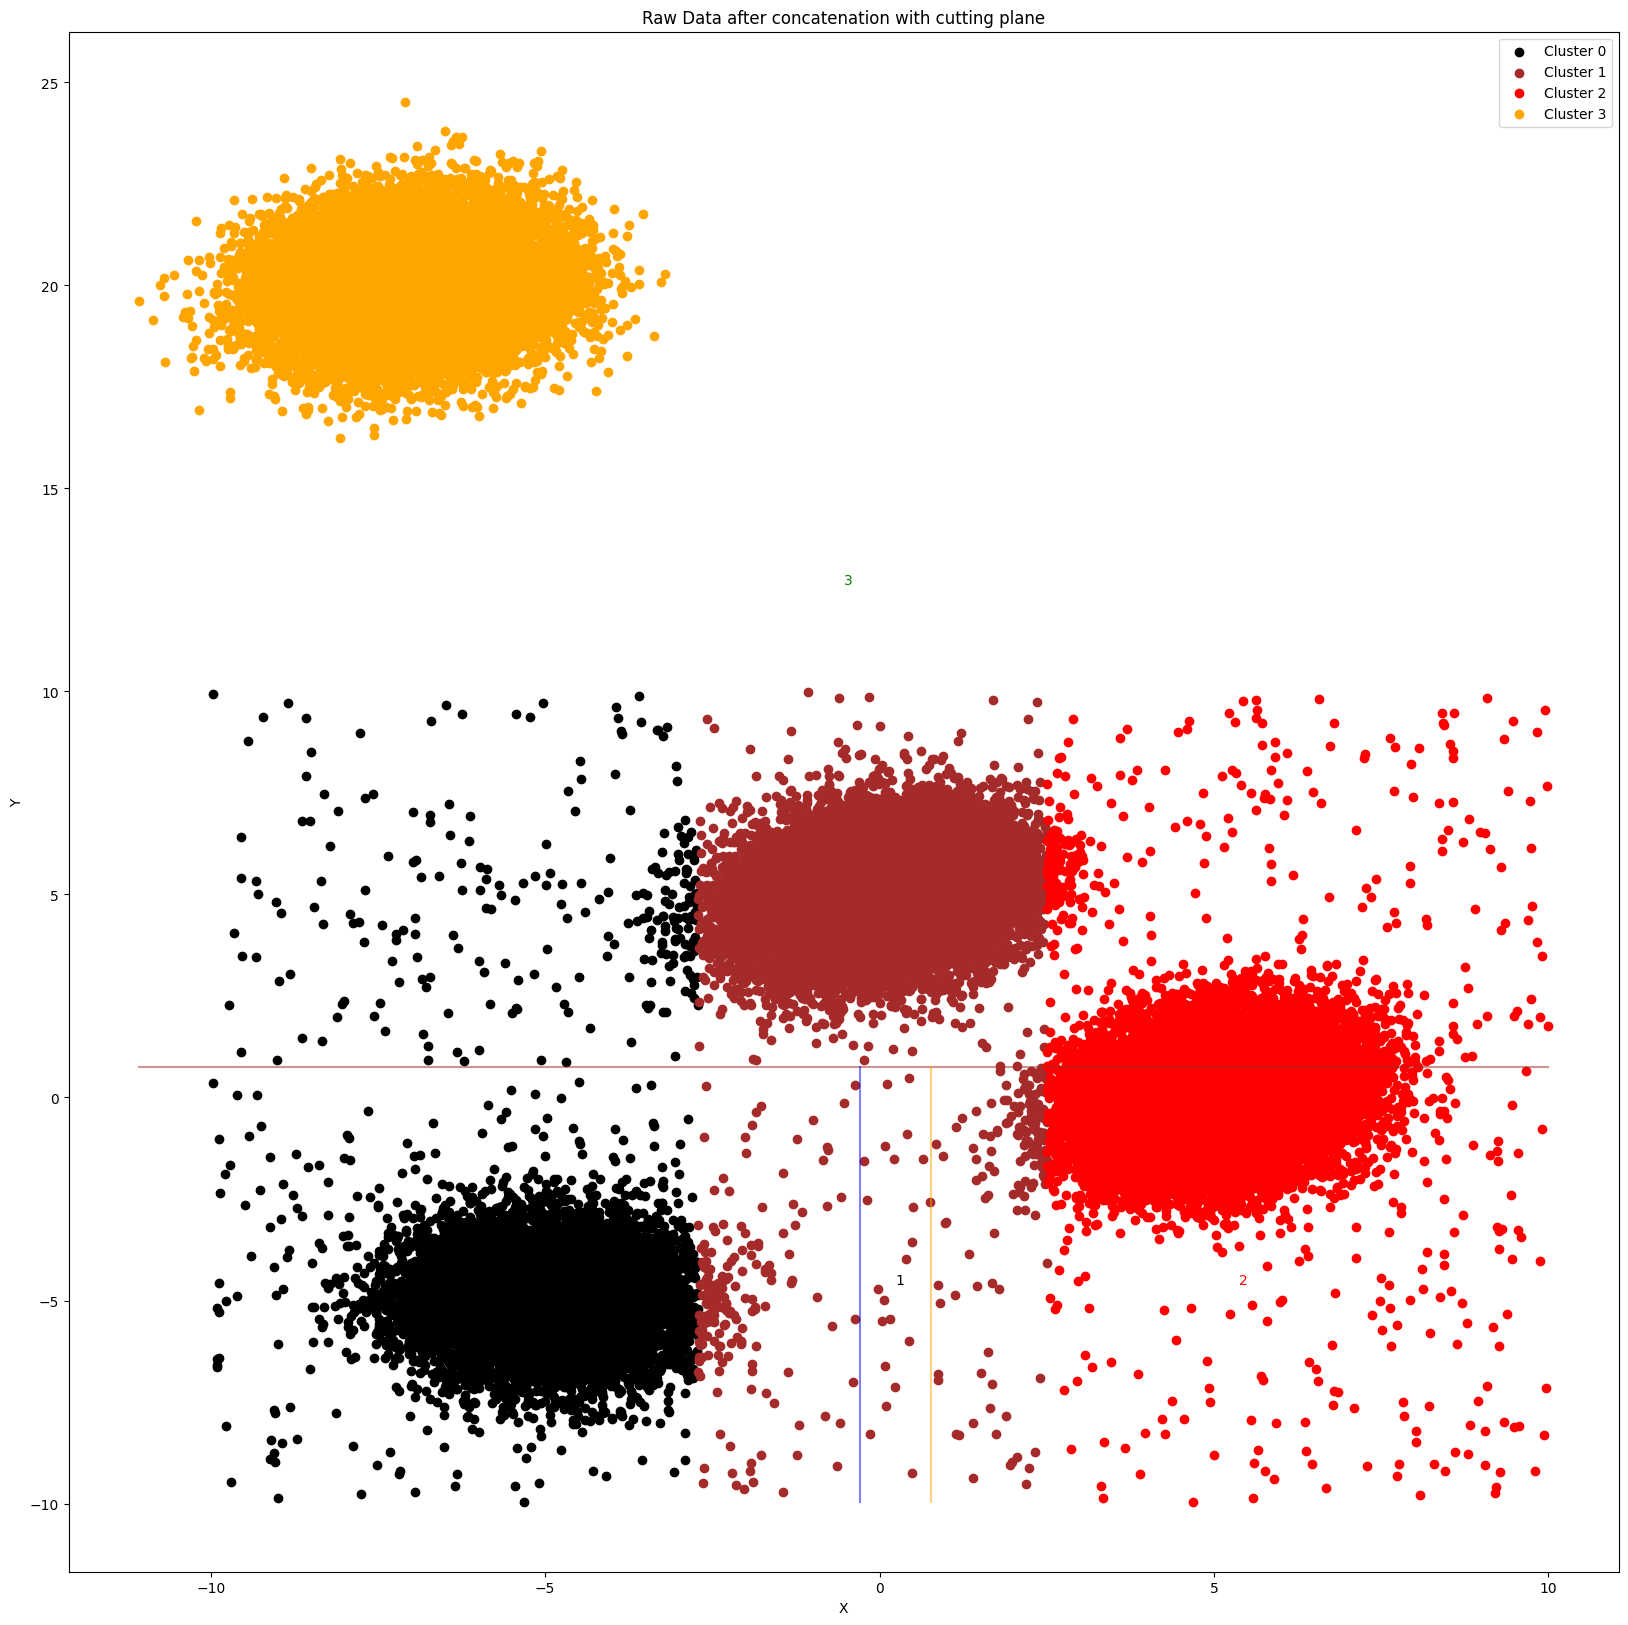

In [25]:
#create 3d plot of the data

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax.scatter(data[:,0], data[:,1])
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.title.set_text('Raw Data after concatenation')
plt.show()

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
for index, cluster in enumerate(optigrid_test.clusters):
    ax.scatter(data[cluster,0], data[cluster,1], label=f'Cluster {index}', color=colors[index%10])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()


#plot all cutting planes
    
#recursively plot all cutting planes. Starting with the root node then traverse the tree to plot all cutting planes

def plot_cutting_planes(ax, node, side, d_prev, x0, x1, y0, y1):       
    if node is None:         
        return
        
    if  node.cutting_planes is None:
        print(f'leaf node - {node.cluster_index}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}')
        if d_prev == 0:
            if side == 0: #left
                ax.text((x0+x1)/2, (y0+y1)/2, f'{node.cluster_index}', color='black')        
            else: #right
                ax.text((x1+x0)/2, (y1+y0)/2, f'{node.cluster_index}', color='red')
        elif d_prev == 1:
            if side == 0: #bottom
                ax.text((x0+x1)/2, (y0+y1)/2, f'{node.cluster_index}', color='orange')        
            else: #top
                ax.text((x1+x0)/2, (y1+y0)/2, f'{node.cluster_index}', color='green')
        return
    else:
        print(f'branch node - {node.cutting_planes}, {side=}, {d_prev=}, {x0=:1.3f}, {x1=:1.3f}, {y0=:1.3f}, {y1=:1.3f}')
            
    for cutting_plane in node.cutting_planes:
        if cutting_plane[1] == 0:
            x = cutting_plane[0] * np.ones(n_points)
            y = np.linspace(y0, y1, n_points )
                        
            if side == 0: #left                
                ax.plot(x, y, alpha=0.5, c='blue')
                #ax.text(x[0], (y0+y1)/2, f'{cutting_plane[0]:.1f}', color='black')
            else:
              
                ax.plot(x, y, alpha=0.5, c='orange')
                #ax.text(x[0], (y0+y1)/2, f'{cutting_plane[0]:.1f}', color='red')

        elif cutting_plane[1] == 1:
            x =  np.linspace(x0, x1, n_points)
            y = cutting_plane[0] * np.ones(n_points)                                   
            
            if side == 0: #bottom              
                ax.plot(x, y, alpha=0.5, c='green')
                #ax.text((x0+x1)/2, y[0], f'{cutting_plane[0]:.1f}', color='black')
            else:               
                ax.plot(x, y, alpha=0.5, c='brown')
                #ax.text((x0+x1)/2, y[0], f'{cutting_plane[0]:.1f}', color='red')               
                  
            
        for child_side, child in enumerate(node.subgrids):
            if child_side == 0:
                if cutting_plane[1] == 0:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, cutting_plane[0], y0, y1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, x1, y0, cutting_plane[0])
            else:
                if cutting_plane[1] == 0:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], cutting_plane[0], x1, y0, y1)
                elif cutting_plane[1] == 1:
                    plot_cutting_planes(ax, child, child_side, cutting_plane[1], x0, x1, cutting_plane[0], y1)
        
  
plot_cutting_planes(ax, optigrid_test.root, side=-1, d_prev=-1, x0=np.min(data[:,0]), x1=np.max(data[:,0]), y0=np.min(data[:,1]), y1=np.max(data[:,1]))

ax.title.set_text('Raw Data after concatenation with cutting plane') 

plt.show()